# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# PRIMERA PARTE: EXTRACCIÓN DE DAT0S

## I. Declaración de librerías

In [1]:
# Extraccion de texto de página web
# ==============================================================================
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys

# Librerías de apoyo
# ==============================================================================
import time
import re
from tqdm import tqdm
from datetime import datetime, timedelta

# Tratamiento de datos
# ==============================================================================
import pandas as pd

# Tratamiento de texto
# ==============================================================================
from nltk.corpus import stopwords
from nltk.tokenize.regexp import regexp_tokenize
import spacy_spanish_lemmatizer # Lematizar en español
import es_core_news_sm
import string
from nltk.tokenize import word_tokenize
from collections import Counter

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# otras configuraciones
# ==============================================================================
tqdm.pandas()

## II. Configuración de selenium para extración de datos

In [2]:
%time
# Utilizar el driver de chrome
chrome_driver_path = "/usr/lib/chromium-browser/chromedriver"
options = webdriver.ChromeOptions()
options.add_argument('--incognito')
options.add_argument('--headless')
options.add_argument("--disable-extensions")
# Flag para optimizar búsquedas
options.add_argument("--disable-gpu")
options.add_argument("--disable-dev-shm-usage")
# En caso se trabaje con Rott o Administrator
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(executable_path=chrome_driver_path, options=options)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.6 µs


___
Para la búsqueda de la normas: se utilizará el buscador de normas legales del "Diario Oficial el Peruano". El procedimiento es el siguiente:

* Con la ayuda de selinum realizar la busqueda en el "buscador de normas legales".
* Extraer todas las secciónes que representan a las normas que fueron publicadas.
* Por cada sección se recorre para extraer:
    * La catergoría
    * El título
    * La URL de la página de contenido
    * La fecha
    * EL resumen

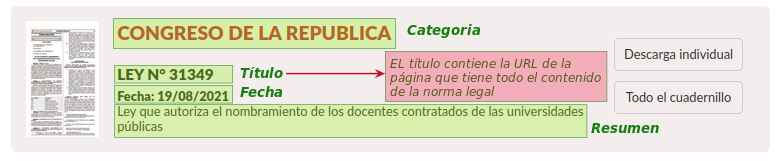

Para la extracción del texto de la páginas que tienen el contenido de las normas, se utilizará BeautifulSoup

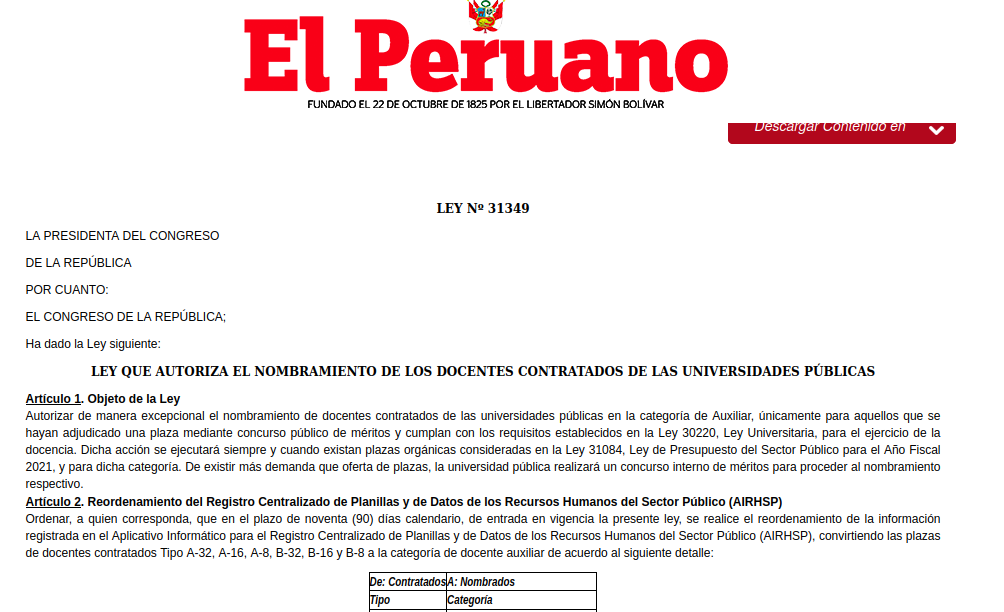
___


In [3]:
%%time
driver.get("https://diariooficial.elperuano.pe/Normas")
time.sleep(3)

CPU times: user 4.43 ms, sys: 986 µs, total: 5.42 ms
Wall time: 4.68 s


## III. Configurar los parámetros para búsqueda

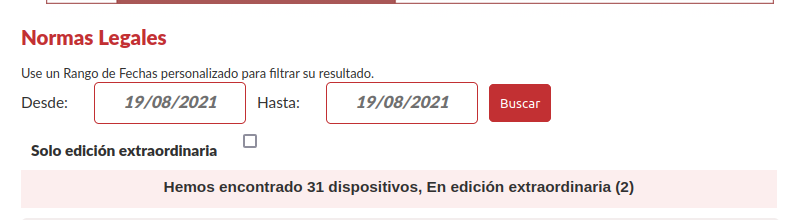

___
Configuar la fechas: para el presente proyecto se extraerá datos de tres meses, los que son 90 días.
___

In [4]:
%%time
numDay = 3*30  # tres meses
today = datetime.now()

startDate = (today - timedelta(days=numDay)).strftime("%d/%m/%Y")
endDate = today.strftime("%d/%m/%Y")

print("="*50)
print("Buscar en el siguiente rango de fechas")
print("="*50)
print("Desde el día:", startDate)
print("Hasta el día:", endDate)

Buscar en el siguiente rango de fechas
Desde el día: 22/05/2021
Hasta el día: 20/08/2021
CPU times: user 1.1 ms, sys: 244 µs, total: 1.34 ms
Wall time: 802 µs


## IV. Realizar búsqueda todas las normas legales posibles

___
Ejecutar la búsqueda
___

In [5]:
%%time
seach_date_begin = driver.find_element_by_id("cddesde")
seach_date_end = driver.find_element_by_id("cdhasta")
seach_date_begin.clear()
seach_date_end.clear()
seach_date_begin.send_keys(startDate)
seach_date_end.send_keys(endDate)
# Invocar el evento Retorno de Carro, para efectuar la búsqueda
seach_date_end.send_keys(Keys.RETURN)
seach_date_end.send_keys(Keys.RETURN)
time.sleep(10)

CPU times: user 18 ms, sys: 48 µs, total: 18 ms
Wall time: 11 s


___
Generar un arreglo con todas las secciones encontradas, recordar que cada sección es un norma legal.
___

In [6]:
%%time
page_source = driver.page_source
pretty_page = BeautifulSoup(page_source, "lxml")
laws = pretty_page.find_all("article", class_="edicionesoficiales_articulos")
len(laws)

CPU times: user 7.08 s, sys: 179 ms, total: 7.26 s
Wall time: 8.53 s


4099

____
Extración de atributos
____

In [7]:
%%time
data = []

counter = 0;

# Iteramos el arreglo de secciones de normas legales
for law in tqdm(laws):
    
    counter += 1
    row = {}
    row["category"] = law.select_one(".ediciones_texto h4").text
    row["title"] = law.select_one(".ediciones_texto h5").text
    row["date"] = law.select_one(".ediciones_texto p b").text.replace("Fecha: ", "").strip()
    row["abstract"] = law.select_one(".ediciones_texto p:nth-of-type(2)").text
    content_url = law.select_one(".ediciones_texto h5 a")["href"]
    content_page = requests.get(content_url, verify=False)
    
    # Extraer todos los parráfos de la página con el contenido de la norma
    paragraphs = BeautifulSoup(content_page.content).find_all(class_="cuerpo")
    
    # Juntar el contenido en el campo content
    row["content"] = " ".join([paragraph.text for paragraph in paragraphs])
    data.append(row)
    if counter % 1000 == 0:
        print("Descanso por 10 segundo para evitar rechazo por DDoS")
        time.sleep(10)

 24%|██▍       | 999/4099 [05:54<18:57,  2.73it/s]  

Descanso por 10 segundo para evitar rechazo por DDoS


 49%|████▉     | 1999/4099 [12:35<12:21,  2.83it/s]  

Descanso por 10 segundo para evitar rechazo por DDoS


 73%|███████▎  | 2999/4099 [23:34<04:46,  3.84it/s]  

Descanso por 10 segundo para evitar rechazo por DDoS


 98%|█████████▊| 3999/4099 [30:12<00:24,  4.14it/s]  

Descanso por 10 segundo para evitar rechazo por DDoS


100%|██████████| 4099/4099 [30:53<00:00,  2.21it/s]

CPU times: user 4min 8s, sys: 4.77 s, total: 4min 13s
Wall time: 30min 53s


## V. Generar dataset base y generar campos pre-procesados previa limpieza
___
Generar el dateset y ver una muestra
___

In [8]:
%%time
dataset_base = pd.DataFrame(data)
dataset_base.sample(5)

CPU times: user 7.86 ms, sys: 0 ns, total: 7.86 ms
Wall time: 7.27 ms


,category,title,date,abstract,content
2152,INSTITUCIONES EDUCATIVAS,RESOLUCION N° 0735-2021/UNTUMBES-CU,02/07/2021,Autorizan viaje del Rector y de autoridades de...,"Tumbes, 25 de junio de 2021 VISTO: El Pedido e..."
329,TRANSPORTES Y COMUNICACIONES,RESOLUCION MINISTERIAL N° 772-2021-MTC/01.03,08/08/2021,Otorgan a FIBERMASS E.I.R.L. Concesión Única p...,"Lima, 6 de agosto de 2021 VISTO, el escrito de..."
2081,MINISTERIO PUBLICO,RESOLUCION N° 983-2021-MP-FN,03/07/2021,Amplían asignación temporal de diversas plazas...,"Lima, 1 de julio de 2021 VISTO Y CONSIDERANDO:..."
2448,ORGANISMO SUPERVISOR DE INVERSION PRIVADA EN T...,RESOLUCION N° 00214-2021-GG/2021,25/06/2021,Amplían plazo para la recepción de comentarios...,"Lima, 24 de junio de 2021 VISTOS: (i) El Proye..."
1097,CORTES SUPERIORES DE JUSTICIA,RESOLUCION ADMINISTRATIVA N° 000494-2021-P-CS...,23/07/2021,Designan jueces supernumerarios en diversos ór...,"Ate, 21 de julio de 2021 VISTAS: La Resolucion..."


In [9]:
___
Declarar funciones de limpieza del texto: contenid tratado para Topic Modelling y Text Summarizer
___

SyntaxError: invalid syntax (<ipython-input-9-1af2629af9f0>, line 2)

In [9]:
# Crear un lista con oraciones y palabras a eliminar de los textos
# Estos textos están en la lista por su continua repetición en todos los registro (normas legales)
black_text_list = [
    "el presidente a. i. del congreso",
    "el presidente de la república considerando",
    "el presidente del congreso",
    "la presidenta a. i. del congreso",
    "la presidenta del congreso",
    "presidenta del congreso",
    "de la república",
    "por cuanto:",
    "el congreso de la república;",
    "ha dado la ley siguiente:",
    "considerando:",
    "artículo",
    "república"
]

# Inciar la lista de stop_word
stop_words = stopwords.words("spanish")
# stop_words.extend(["", ""])

# Cargamos dicionario para lematizar en español
lm = es_core_news_sm.load()

# Función de limpieza para topic modeling
def text_clean_for_topic(text: str):

    # Convertir a minúscula
    txt = text.lower()

    # Remover lista negras de frases
    for black_text in black_text_list:
        txt = txt.replace(black_text, " ")

    # Remover signos de puntuación
    txt = re.sub('[%s]' % re.escape(string.punctuation), ' ', txt)

    # Remover números
    txt = re.sub(r'\w*\d+\w*', '', txt)

    # Remover caracteres unicode y números excepto tíldes y ñ
    txt = re.sub("[^a-záéíóúüñ ]+", "", txt)

    # Aplicar Lemmatize
    txt = " ".join([word.lemma_ for word in lm(txt) if word.lemma_ not in stop_words])

    # Remover palabras menos de tres caracteres
    txt = re.sub(r'\b\w{1,3}\b', '', txt)

    # Remover espacios vacios
    txt = txt = re.sub(r"\s+", " ", txt)

    # Remover espacios en inicio y fin
    txt = txt.strip()

    return txt

# Función de limpieza para sumarización
def text_clean_for_summarize(text: str):

    # Convertir a minúscula
    txt = text.lower()

    # Remover lista negras de frases
    for black_text in black_text_list:
        txt = txt.replace(black_text, " ")

    # Remover signos de puntuación
    txt = re.sub('[%s]' % re.escape(string.punctuation), ' ', txt)

    # Remover números
    txt = re.sub(r'\w*\d+\w*', '', txt)

    # Remover caracteres unicode y números excepto tíldes y ñ
    txt = re.sub("[^a-záéíóúüñ ]+", "", txt)

    # Remover stop_words
    txt = " ".join([w for w in txt.split() if w not in stop_words])

    # Remover palabras menos de tres caracteres
    txt = re.sub(r'\b\w{1,3}\b', '', txt)

    # Remover espacios vacios
    txt = txt = re.sub(r"\s+", " ", txt)

    # Remover espacios en inicio y fin
    txt = txt.strip()

    return txt

___
Apliar limpieza que se almacenarán en campo nuevos:
* **content_for_topic**
* **content_for_summary**
* **abstract_for_summary**
___

In [13]:
%%time
dataset_base['content_for_topic'] = dataset_base.content.progress_apply(text_clean_for_topic)
dataset_base['content_for_summary'] = dataset_base.content.progress_apply(text_clean_for_summarize)
dataset_base['abstract_for_summary'] = dataset_base.abstract.progress_apply(text_clean_for_summarize)
dataset_base.sample(5)

100%|██████████| 2124/2124 [04:42<00:00,  7.53it/s]

CPU times: user 4min 37s, sys: 5.25 s, total: 4min 42s
Wall time: 4min 42s


In [15]:
# Ejemplo de un registro del campo pre-procesada
dataset_base.content_for_topic[0][0:1000]

'lima agosto encontrar vacante plaza correspondiente puesto asesor gabinete asesor despacho ministerial ministerio economía finanza contexto resultar necesario designar persona ejerzar función inherente referido puesto conformidad dispuesto orgánico poder ejecutivo regular participación poder ejecutivo nombramiento designación funcionario público texto integrado actualizado reglamento organización función ministerio economía finanza aprobado mediante resolución ministerial resolver artículo único designar señora aurora tassar lafosse puesto asesora gabinete asesor despacho ministerial ministerio economía finanza regístrese comuníquese publique pedro francke ballvé ministro economía finanza'

In [ ]:
___
Verificar si existe columnas con valores nulos y eliminarlos
___

In [ ]:
# Limpieza del dataset
print("Dimensiones:", dataset_base.shape)
print("Filas que no contiene valores nulos:", len(dataset_base[dataset_base.content_for_topic.notna()]))
print("Filas con valores nulos:", len(dataset_base[dataset_base.isnull().any(axis=1)]))

In [ ]:
# Eliminado los que contien valores nulos
dataset_base.dropna(inplace=True)
print("Dimensiones:", dataset_base.shape)

## VI. Revisar el corpous

Se revisará las columnas  
* **content_for_topic**
* **content_for_summary**

___
<h2> Tokenizer sin Lematización </h2>

___

In [73]:
# Tokenización
tokens = word_tokenize(" ".join(dataset_base.content_for_topic))

# Número de tokens
num_tokens = len(tokens)
vocabulary_size = len(list(set(tokens)))

print("="*80)
print("Número de tokens:", num_tokens)
print("Tamaño de vocabulario:", vocabulary_size)
print("="*80)

False

___
Estadística con las 10 palabras mas frecuentes
___

In [ ]:
%%time
c_tokens = Counter(tokens)
pd.DataFrame(c_tokens.most_common(10), columns=("words", "counts"))

___
<h2> Tokenizer cmon Lematización </h2>

___

In [ ]:
# Tokenización
tokens = word_tokenize(" ".join(dataset_base.content_for_summary))

# Número de tokens
num_tokens = len(tokens)
vocabulary_size = len(list(set(tokens)))

print("="*80)
print("Número de tokens:", num_tokens)
print("Tamaño de vocabulario:", vocabulary_size)
print("="*80)

___
Estadística con las 10 palabras mas frecuentes
___

In [ ]:
%%time
c_tokens = Counter(tokens)
pd.DataFrame(c_tokens.most_common(10), columns=("words", "counts"))

## VII. Guardar el dataset base en un CSV para las siguientes fase de desarrollo del proyecto

In [ ]:
%%time
# Guardar a data para la siguiente notebooks
dataset_base.to_csv("dataset_base.csv", sep='\t', encoding='utf-8', index=False)